# Training an LSTM network to detect punches during shadow boxing
During this project I will be training a Long Short Term Memory (LSTM) network to detect which punch is being thrown during shadow boxing. This project was inspired by a talk given by [Zack Akil](https://github.com/ZackAkil) about using Google's VideoIntelligence API to analyse a penalty shootout, as well as [Anudeep Ayinaparthi](https://github.com/anudeepayina/CricketTracker)'s cricket shot classifier.

### LSTM vs RNN
An LSTM is a type of recurrent neural network (RNN), which is able to learn from longer sequences of input data than a regular RNN, without "forgetting" information from the earlier datapoints in the sequence. This problem is known as ['vanishing gradients'](https://towardsdatascience.com/the-exploding-and-vanishing-gradients-problem-in-time-series-6b87d558d22), and occurs due to the way RNNs are trained, where as gradients are passed back through the network during the backpropagation phase, they get smaller and smaller due to the chain rule and eventually become so small that they can not be used to update the weights and biases of the network (see also: [exploding gradients](https://towardsdatascience.com/the-exploding-and-vanishing-gradients-problem-in-time-series-6b87d558d22)). 

An LSTM network solves this problem through the a combination of 'forget gates', 'input gates' and 'output gates'. This combination of gates in an LSTM cell allows only the most salient signal information to be passed through the network, by using the *sigmoid* and *tanh* functions to compress information between the range of 0 and 1. This [article](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21) does a great job of explaining how these gates combine to achieve this.

### Setup
In this project we will be using Google Cloud Platform's *VideoIntelligence* API to analyse input videos, so we will need to set up our Google Cloud Platform account accordingly. A great guide for doing this can be found [here](https://github.com/google/making_with_ml/blob/master/sports_ai/Sports_AI_Analysis.ipynb)

### Importing libraries


In [1]:
import csv
import json
import math
import os
import sys

import pandas as pd
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
import numpy as np

from google.cloud import videointelligence_v1 as videointelligence
from google.oauth2 import service_account

Set up GCP environment variables

In [802]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = './PATH-TO-KEY.json' # This key is created in GCP and stored locally

This function is taken from VideoIntelligence API documentation, found [here]( https://cloud.google.com/video-intelligence/docs/people-detection)

In [3]:
def detect_person(gcs_uri="gs://YOUR_BUCKET_ID/path/to/your/video.mp4", output_uri=""):
    """Detects people in a video."""
    client = videointelligence.VideoIntelligenceServiceClient()

    # Configure the request
    config = videointelligence.types.PersonDetectionConfig(
        include_bounding_boxes=True,
        include_attributes=True,
        include_pose_landmarks=True,
    )

    context = videointelligence.types.VideoContext(person_detection_config=config)

    # Start the asynchronous request
    operation = client.annotate_video(
        request={
            "features": [videointelligence.Feature.PERSON_DETECTION],
            "input_uri": gcs_uri,
            "output_uri": output_uri,
            "video_context": context,
        }
    )

    print("\nProcessing video for person detection annotations.")
    result = operation.result(timeout=300)

    print("\nFinished processing.\n")

    # Retrieve the first result, because a single video was processed.
    annotation_result = result.annotation_results[0]

    for annotation in annotation_result.person_detection_annotations:
        print("Person detected:")
        for track in annotation.tracks:
            print(
                "Segment: {}s to {}s".format(
                    track.segment.start_time_offset.seconds
                    + track.segment.start_time_offset.microseconds / 1e6,
                    track.segment.end_time_offset.seconds
                    + track.segment.end_time_offset.microseconds / 1e6,
                )
            )

            # Each segment includes timestamped objects that include
            # characteristics - -e.g.clothes, posture of the person detected.
            # Grab the first timestamped object
            timestamped_object = track.timestamped_objects[0]
            box = timestamped_object.normalized_bounding_box
            print("Bounding box:")
            print("\tleft  : {}".format(box.left))
            print("\ttop   : {}".format(box.top))
            print("\tright : {}".format(box.right))
            print("\tbottom: {}".format(box.bottom))

            # Attributes include unique pieces of clothing,
            # poses, or hair color.
            print("Attributes:")
            for attribute in timestamped_object.attributes:
                print(
                    "\t{}:{} {}".format(
                        attribute.name, attribute.value, attribute.confidence
                    )
                )

            # Landmarks in person detection include body parts such as
            # left_shoulder, right_ear, and right_ankle
            print("Landmarks:")
            for landmark in timestamped_object.landmarks:
                print(
                    "\t{}: {} (x={}, y={})".format(
                        landmark.name,
                        landmark.confidence,
                        landmark.point.x,  # Normalized vertex
                        landmark.point.y,  # Normalized vertex
                    )
                )

    return annotation_result


Here we loop through all the required videos in the GCP bucket, calling the *detect_person* function on each and storing the results in another GCP bucket. 
NB: These files all exist in the repository so this is just to demonstrate how to use the VideoIntelligence API.

In [801]:
# Process all jab videos
for i in range(1,50):
    input_uri = 'gs://op-boxing-analysis2/LSTM_data/jab%i.mp4' %i
    output_uri = "gs://op-boxing-analysis2/jab%i.json" %i
    results = detect_person(input_uri, output_uri)

# Process all cross videos
for i in range(1,50):
    input_uri = 'gs://op-boxing-analysis2/LSTM_data/cross%i.mp4' %i
    output_uri = "gs://op-boxing-analysis2/cross%i.json" %i
    results = detect_person(input_uri, output_uri)

# Process all left hook videos    
for i in range(1,50):
    input_uri = 'gs://op-boxing-analysis2/LSTM_data/lefthook%i.mp4' %i
    output_uri = "gs://op-boxing-analysis2/lefthook%i.json" %i
    results = detect_person(input_uri, output_uri)

# Process all right uppercut videos
for i in range(1,50):    
    input_uri = 'gs://op-boxing-analysis2/LSTM_data/rightuppercut%i.mp4' %i
    output_uri = "gs://op-boxing-analysis2/rightuppercut%i.json" %i
    results = detect_person(input_uri, output_uri)


Next, we copy all of the results files into our local *data* directory for processing NB: These files all exist in the repository so you do not need to do it again!

In [803]:
!gsutil -m cp "gs://op-boxing-analysis2/*.json" data

This helper function takes in a person and rearranges the data so it's in a timeline, which will make it easier for us to work with


In [6]:
def analyzePerson(person):
  frames = []
  for track in person['tracks']:
    # Convert timestamps to seconds
    for ts_obj in track['timestamped_objects']:
      time_offset = ts_obj['time_offset']
      timestamp = 0
      if 'nanos' in time_offset:
        timestamp += time_offset['nanos'] / 10**9
      if 'seconds' in time_offset:
        timestamp += time_offset['seconds']
      if 'minutes' in time_offset:
        timestamp += time_offset['minutes'] * 60
      frame= {'timestamp' : timestamp}
      for landmark in ts_obj['landmarks']:
        frame[landmark['name'] + '_x'] = landmark['point']['x']
        # Subtract y value from 1 because positions are calculated
        # from the top left corner
        frame[landmark['name'] + '_y'] = 1 - landmark['point']['y']
      frames.append(frame)
  sorted(frames, key=lambda x: x['timestamp'])
  return frames

Here we loop through all of the results files stored in the *data* directory, run the helper function on each, and then write the results to a new CSV file in the same directory. Alternatively, you could keep all these values only in memory but during development I wanted to have the results saved to disk for convenience.

In [7]:
for punch in os.listdir('data'):
    if punch.split('.')[-1] != 'json':
        continue
    root = punch.split('.')[0]
    fil = os.path.join('data', punch)
    data = json.load(open(fil))
    people_annotations = data['annotation_results'][0]['person_detection_annotations']
    annotationsPd = pd.DataFrame(analyzePerson(people_annotations[0]))
    annotationsPd = annotationsPd.sort_values('timestamp', ascending=True)
    with open(os.path.join('data', root + '.csv'), 'w') as out:
        annotationsPd.to_csv(out, index=False)


Here we define some helper functions that can augment our data by computing angles between the vectors joining up landmarks, such as the angle the upper and lower arm make at the elbow joint. This will be useful as we used a fixed camera to record videos front-on, there is no depth information when extending arms during a punch.

In [145]:
class Point:
  def __init__(self, x, y):
    self.x = x
    self.y = y 

In [146]:
def getAngle(a, b, c):
    ang = math.degrees(math.atan2(c.y-b.y, c.x-b.x) - math.atan2(a.y-b.y, a.x-b.x))
    return ang

In [148]:
def computeElbowAngle(row, which='right'):
  wrist = Point(row[f'{which}_wrist_x'], row[f'{which}_wrist_y'])
  elbow = Point(row[f'{which}_elbow_x'], row[f'{which}_elbow_y'])
  shoulder = Point(row[f'{which}_shoulder_x'], row[f'{which}_shoulder_y'])
  return getAngle(wrist, elbow, shoulder)

def computeShoulderAngle(row, which='right'):
  elbow = Point(row[f'{which}_elbow_x'], row[f'{which}_elbow_y'])
  shoulder = Point(row[f'{which}_shoulder_x'], row[f'{which}_shoulder_y'])
  hip = Point(row[f'{which}_hip_x'], row[f'{which}_hip_y'])
  return getAngle(hip, shoulder, elbow)

def computeKneeAngle(row, which='right'):
  hip = Point(row[f'{which}_hip_x'], row[f'{which}_hip_y'])
  knee = Point(row[f'{which}_knee_x'], row[f'{which}_knee_y'])
  ankle = Point(row[f'{which}_ankle_x'], row[f'{which}_ankle_y'])
  return getAngle(ankle, knee, hip)

Here we read the CSV files previously created into memory and perform some data preprocessing, as well as storing the data labels to be used for training. 
- Firstly we need to make sure that all columns exist in every dataframe, if one does not exist then we will create it and fill with zeros. 
- We will drop the columns that track the position of the eyes and ears, as these are not expected to provide much information, and the nose position can be used as a proxy for head position. 
- For all of the positional data, we need to remove the timestamps and then normalize the landmark positions to be relative to the first position (this is because the start position of each video clip will not be the same).
- We will also compute the angle data  and add these columns to the dataframe, after the other results have been normalised.

This is done below:

In [750]:
import glob
punches_normalised = []
label_data = []
for fil in glob.glob('data/*.csv'):
    
    # Read data and drop the superfluous columns
    punch_data = pd.read_csv(fil)
    punch_data = punch_data.drop(['timestamp','left_eye_x', 'left_eye_y',
       'right_eye_x', 'right_eye_y', 'left_ear_x', 'left_ear_y', 'right_ear_x',
       'right_ear_y'], axis=1)
    
    # Here we skip over the files for some of the classes,
    # as we are focusing on just the Jab, Cross, Left hook and Right uppercut
    if "leftslip" in fil:
        continue
    if "rightslip" in fil:
        continue
    if "leftroll" in fil:
        continue
    if "rightroll" in fil:
        continue 
    if "leftuppercut" in fil:
        continue
    if "righthook" in fil:
        continue

    
    # Check all columns are present, if not, create and fill with zeros
    for col in ['nose_x', 'nose_y', 'left_shoulder_x', 'left_shoulder_y', 'right_shoulder_x',
       'right_shoulder_y', 'left_elbow_x', 'left_elbow_y', 'right_elbow_x',
       'right_elbow_y', 'left_wrist_x', 'left_wrist_y', 'right_wrist_x',
       'right_wrist_y', 'left_hip_x', 'left_hip_y', 'right_hip_x',
       'right_hip_y', 'left_knee_x', 'left_knee_y', 'right_knee_x',
       'right_knee_y', 'left_ankle_x', 'left_ankle_y', 'right_ankle_x',
       'right_ankle_y']:
        if not col in punch_data.columns:
            punch_data[col] = 0
    
    # Calculate angles
    left_shoulder_angle = punch_data.apply(computeShoulderAngle, which='left',axis=1)
    right_shoulder_angle = punch_data.apply(computeShoulderAngle,axis=1)

    left_elbow_angle = punch_data.apply(computeElbowAngle, which='left',axis=1)
    right_elbow_angle = punch_data.apply(computeElbowAngle,axis=1)

    left_knee_angle = punch_data.apply(computeKneeAngle, which='left',axis=1)
    right_knee_angle = punch_data.apply(computeKneeAngle,axis=1)
    
    
    # Drop the superfluous columns
    punch_data = punch_data.drop(['left_eye_x', 'left_eye_y',
       'right_eye_x', 'right_eye_y', 'left_ear_x', 'left_ear_y', 'right_ear_x',
       'right_ear_y'], axis=1)
    
    # Fill all null values with zeros and then normalise all positional data
    punch_data = punch_data.fillna(0)
    punch_data = punch_data.iloc[:,:] - punch_data.iloc[0,:]

    # Finally, add the angle data to the dataframe
    punch_data['left_shoulder_angle'] = left_shoulder_angle
    punch_data['right_shoulder_angle'] = right_shoulder_angle
    punch_data['left_elbow_angle'] = left_elbow_angle
    punch_data['right_elbow_angle'] = right_elbow_angle
    punch_data['left_knee_angle'] = left_knee_angle
    punch_data['right_knee_angle'] = right_knee_angle
    
    # Append results to array containing data for each punch
    punches_normalised.append(punch_data.values)
    
    # Get label data from file name and add to array containing labels
    label_data.append(fil.split('/')[-1].split('.')[0].strip('0987654321'))


Here we can see that we have a total of 195 videos, with roughly 50 videos per class

In [787]:
len(punches_normalised)

195

If we look at the spread of the video lengths, we can see that the majority of sequences have length 21, while the longest is 33. As we want all sequences to be of the same length for training, we will use this information to pad the shorter sequences with zeros to simulate landmarks returning to their original positions. We also save the number of features that each punch has, to be used when defining the LSTM model.

Max length:  33
Number of features:  32


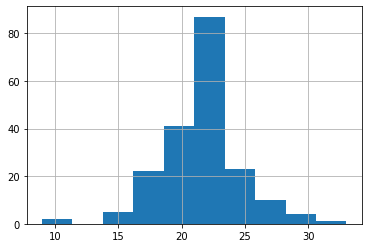

In [791]:
len_sequences = []
for one_seq in punches_normalised:
    len_sequences.append(len(one_seq))
    
pd.Series(len_sequences).hist()

max_len = max(len_sequences)
print("Max length: ", max_len )

num_feats = punches_normalised[0].shape[1]
print("Number of features: ", num_feats)


Here we pad each punch in the sequence such that each has the same number of data points

In [755]:
from keras.preprocessing import sequence

final_seq_punches=sequence.pad_sequences(punches_normalised, maxlen=max_len, padding='post', dtype='float')


Now we can start to build our model. We will begin by importing all the necessary libraries.

In [758]:
import pandas as pd
import numpy as np
from numpy import load
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

Let's create a train/test split using our data, stratifying on the label data to ensure that the split of classes is equal across training and testing data.

In [796]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(final_seq_punches,label_data,test_size = 0.2, stratify=label_data)

Now we need to encode our labels to be used in training the model. This will encode the labels to integer values rather than one-hot encoding, hence when calculating the loss we will need to use *sparse categorical cross-entropy* rather than *categorical cross-entropy*.

In [760]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)


Now we are ready to define our LSTM model. Using the *Sequential* model structure in Keras, I have built a model with 5 layers, 10 hidden nodes per layer, and a dropout rate of 0.2 per layer to prevent overfitting. This is then fed into a Dense output layer with 4 class outputs, activated using the *softmax* function. NB these hyperparameters were found through trial and error, and may not be completely optimised as I did not implement a full grid-search.

In [777]:
model = Sequential()
model.add(LSTM(10,activation="relu",input_shape = (max_len, num_feats),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(10,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(10,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(10,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(10))
model.add(Dropout(0.2))
model.add(Dense(4,activation="softmax"))

Here we compile the model to use the *Adam* optimiser, *sparse categorical cross-entropy loss* (as it is a multi-class problem) and using *accuracy* as the metric to be monitored to judge performance.

In [778]:
model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

Here we define some checkpoints so that the model saves the best weights during the training process.

In [779]:
checkpoint = ModelCheckpoint('weights.hdf5',monitor="val_loss",save_best_only=True)
earlystop = EarlyStopping(monitor="val_accuracy",patience=3,mode="max")
callbackslist = [checkpoint]

Time to train!

In [780]:
training = model.fit(x_train,y_train,epochs=50,batch_size=1,validation_split=0.2,verbose=1,callbacks=callbackslist)
history = training.history

Epoch 1/50
124/124 [==============================] - 10s 35ms/step - loss: 1.3733 - accuracy: 0.2903 - val_loss: 1.3416 - val_accuracy: 0.5000
Epoch 2/50
124/124 [==============================] - 3s 24ms/step - loss: 1.2623 - accuracy: 0.4839 - val_loss: 1.1867 - val_accuracy: 0.4688
Epoch 3/50
124/124 [==============================] - 3s 23ms/step - loss: 1.1236 - accuracy: 0.5242 - val_loss: 0.9278 - val_accuracy: 0.6875
Epoch 4/50
124/124 [==============================] - 3s 23ms/step - loss: 0.9289 - accuracy: 0.6613 - val_loss: 1.0644 - val_accuracy: 0.5938
Epoch 5/50
124/124 [==============================] - 3s 23ms/step - loss: 0.7289 - accuracy: 0.7339 - val_loss: 0.7852 - val_accuracy: 0.7188
Epoch 6/50
124/124 [==============================] - 3s 23ms/step - loss: 0.8450 - accuracy: 0.6452 - val_loss: 0.7141 - val_accuracy: 0.7812
Epoch 7/50
124/124 [==============================] - 3s 23ms/step - loss: 0.6894 - accuracy: 0.6774 - val_loss: 0.8550 - val_accuracy: 0.718

Let's take a look at how the accuracy and loss changes during the training process

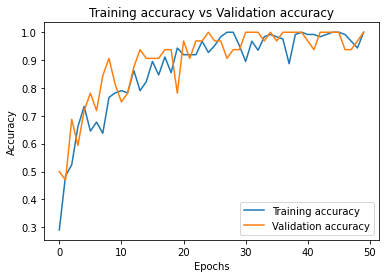

In [793]:
plt.plot(history["accuracy"], label='Training accuracy')
plt.plot(history["val_accuracy"], label='Validation accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

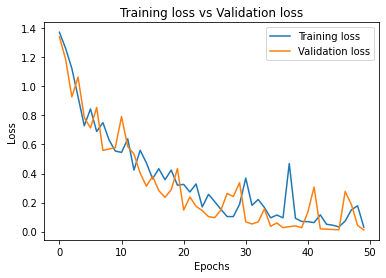

In [794]:
plt.plot(history["loss"], label='Training loss')
plt.plot(history["val_loss"], label='Validation loss')
plt.title('Training loss vs Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Finally, using the best model from our training data, lets make some predictions on the test data

In [795]:
#Load best model
model.load_weights('weights.hdf5')
#Predict using best model
results = model.evaluate(x_test,y_test,batch_size=1)
print("test loss, test acc:", results)

39/39 [==============================] - 0s 6ms/step - loss: 0.0492 - accuracy: 0.9744
test loss, test acc: [0.049229301512241364, 0.9743589758872986]


We can see that using these model hyperparameters, we are able to get an accuracy of 97.4%! In this model we only used 4 of the 6 punch classes (10 if you include slips and rolls) that we have data for as including the other classes was found to significantly reduce the model performance. Inclusion of these classes without a reduction in performance can hopefully be achieved with more work on model design/feature engineering, feel free to clone this repository and have a go yourselves!